# Data Lab 7
AR models

In [54]:
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from datetime import datetime
months =[datetime(2019, imon, 1) for imon in np.arange(1,12+1)]
month_str = [date_obj.strftime('%b') for date_obj in months]
m_str = [w[0] for w in month_str];

# Get color order
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [55]:
# Sep Nino 3.4
n34_Sep_url = 'http://iridl.ldeo.columbia.edu/home/.tippett/.scratch/.APMA4990/.n34_Sep/dods'
n34_Sep_ds = xr.open_dataset(n34_Sep_url)
n34_Sep = n34_Sep_ds.n34_Sep - n34_Sep_ds.n34_Sep.mean('T')
#n34_Sep.plot();

In [56]:
# 2-meter temperature
t2m_DJF_url = 'http://iridl.ldeo.columbia.edu/home/.tippett/.scratch/.APMA4990/.t2m_DJF/dods'
t2m_DJF_ds = xr.open_dataset(t2m_DJF_url)
t2m = t2m_DJF_ds.t2m_DJF
#t2m.mean('T').plot()

## Comments on homework 5

### 1. Weighted average
- Cosine weighting needs to be normalized
- "weighted" 
- mean('X').mean('Y') does not give you what you want which is mean(('X','Y')) when the domain is not a rectangle.

/opt/conda/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


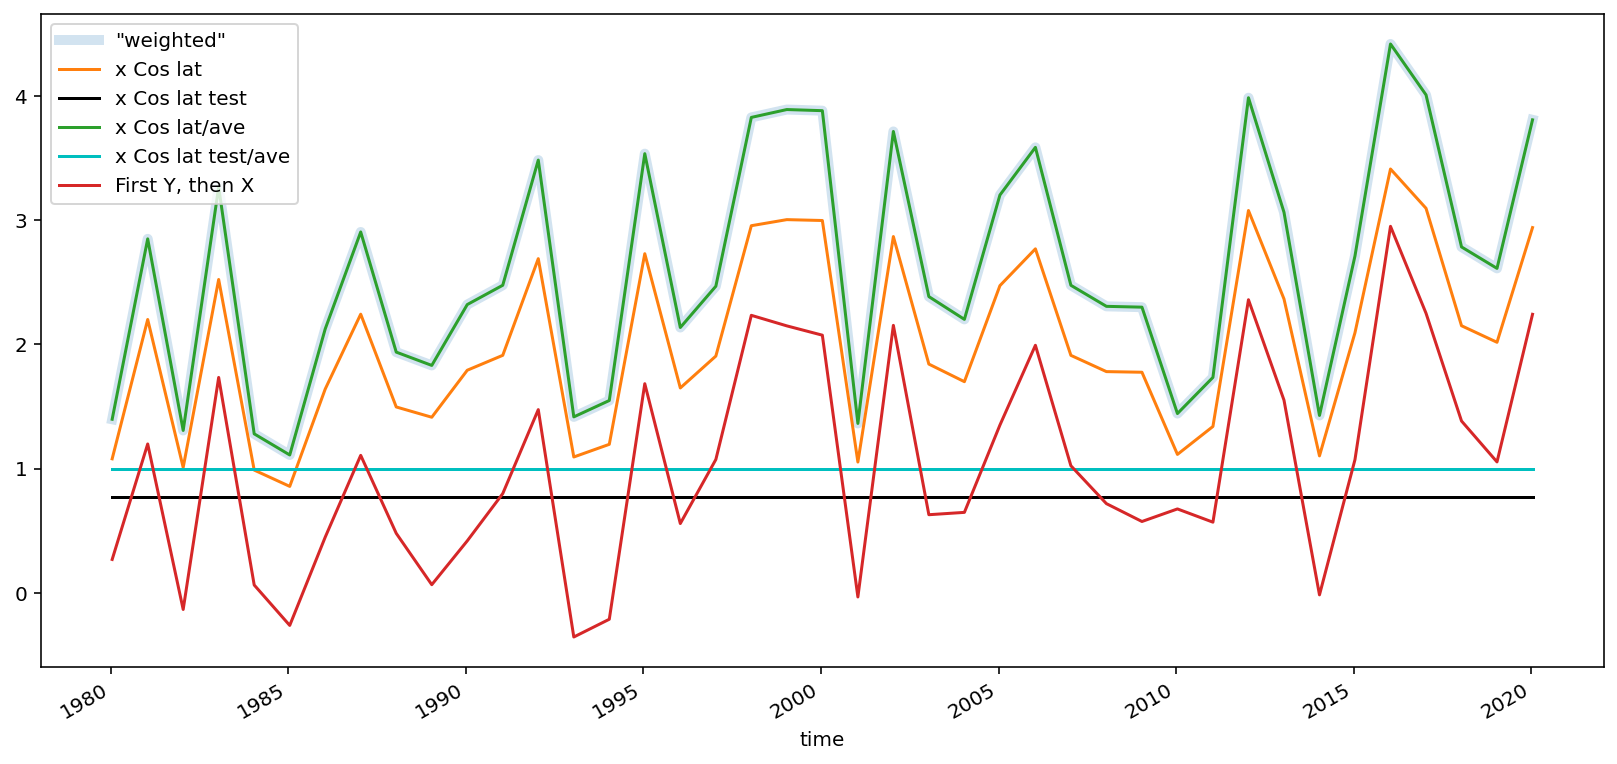

In [57]:
w = np.cos(np.deg2rad(t2m.Y))
w_normalized = w/(w * (t2m*0.0 + 1)).mean(('X', 'Y'))

fig, ax = plt.subplots(figsize = (14,6))
t2m.weighted(w).mean(('X', 'Y')).plot(ax = ax, linewidth = 5, alpha = 0.2, label = '"weighted"')

(t2m * w).mean(('X', 'Y')).plot(ax = ax, label = 'x Cos lat')
((t2m*0 + 1) * w).mean(('X', 'Y')).plot(ax = ax, color = 'k', label = 'x Cos lat test')

(t2m * w_normalized).mean(('X', 'Y')).plot(ax = ax, label = 'x Cos lat/ave')
((t2m*0 + 1) * w_normalized).mean(('X', 'Y')).plot(ax = ax, color = 'c', label = 'x Cos lat test/ave')

(t2m * w_normalized).mean('Y').mean('X').plot(ax = ax, label = 'First Y, then X')

ax.legend();

### 2. Linear regression on a map. 

Matrix-matrix multiplication = first matrix times the columns of the second matrix

If you want to multiply a matrix times a lot of (column) vectors, put the vectors in a matrix (columns).

In [58]:
ncol = 8
A = np.random.randint(-9, high=9, size = (3,3))
print(A)
print('---')

v = np.random.randint(-9, high=9, size = (3,ncol))
print(A @ v)
print('---')

for ii in range(0, ncol):
    print(A @ v[:,ii].reshape(-1,1), end='\n\n')
print('---')

v3d = np.reshape(v, (3,2,4))
for ii in range(0, 2):
    for jj in range(0, 4):
        print(A @ v3d[:,ii,jj].reshape(-1,1), end='\n\n')

[[-5 -7  1]
 [-1 -3  1]
 [ 6 -2 -9]]
---
[[  6  56 -87 -39  53 -21 -80 -53]
 [ -2  16 -31 -11  17   3 -36 -21]
 [-80  68  81  52  82 -19  83 -43]]
---
[[  6]
 [ -2]
 [-80]]

[[56]
 [16]
 [68]]

[[-87]
 [-31]
 [ 81]]

[[-39]
 [-11]
 [ 52]]

[[53]
 [17]
 [82]]

[[-21]
 [  3]
 [-19]]

[[-80]
 [-36]
 [ 83]]

[[-53]
 [-21]
 [-43]]

---
[[  6]
 [ -2]
 [-80]]

[[56]
 [16]
 [68]]

[[-87]
 [-31]
 [ 81]]

[[-39]
 [-11]
 [ 52]]

[[53]
 [17]
 [82]]

[[-21]
 [  3]
 [-19]]

[[-80]
 [-36]
 [ 83]]

[[-53]
 [-21]
 [-43]]



In [59]:
# Linear regression at every gridpoint
from numpy.linalg import inv

N, nlat, nlon = t2m.shape
p = 2
XX = np.empty((N, p))
XX[:, 0] = 1
XX[:, 1] = n34_Sep[:-1]
y = t2m.values.reshape(N, nlat * nlon)

beta = inv(XX.T@XX)@XX.T@y
print(beta.shape)
yhat = XX@beta
R = y - yhat
sigma_hat = np.std(R, axis = 0)
print(sigma_hat.shape)

(2, 9424)
(9424,)


### 3. Tercile boundarys are also climatology (was not clear?). 

Also use all the data in the regression, not just climo period.

In [60]:
threshold_below = t2m.sel(T = slice('1980', '2010')).quantile([1./3., 2./3.], dim='T')

/opt/conda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


# "I come to bury AR, not to praise them"

Last time we fit an AR(1) model to Nino 3.4

$$ X_t = \phi X_{t-1} + W_t\,, $$

$$ E[X_t | x_0] = \phi^t x_0 $$

found that the residuals $X_t - \hat{X}_t = X_t - \hat{\phi} X_{t-1}$ were correlated in time, which led to an AR(2) model

$$ X_t = \phi_1 X_{t-1} + \phi_2 X_{t-2} + W_t\,, $$

whose residuals showed no evidence for autocorrelation.

Nonetheless, AR models are stationary. Their statistics are invariant to shifts in time.

In [61]:
# Read nino 3.4 and compute anomalies
n34_url = 'http://iridl.ldeo.columbia.edu/home/.tippett/.scratch/.APMA4990/.n34/dods'
n34_ds = xr.open_dataset(n34_url)
n34 = n34_ds.n34
nmonths = len(n34)
n34a = n34.groupby('T.month') - n34.groupby('T.month').mean()

# Nino 3.4 is not stationary

## 1. Variance varies by month

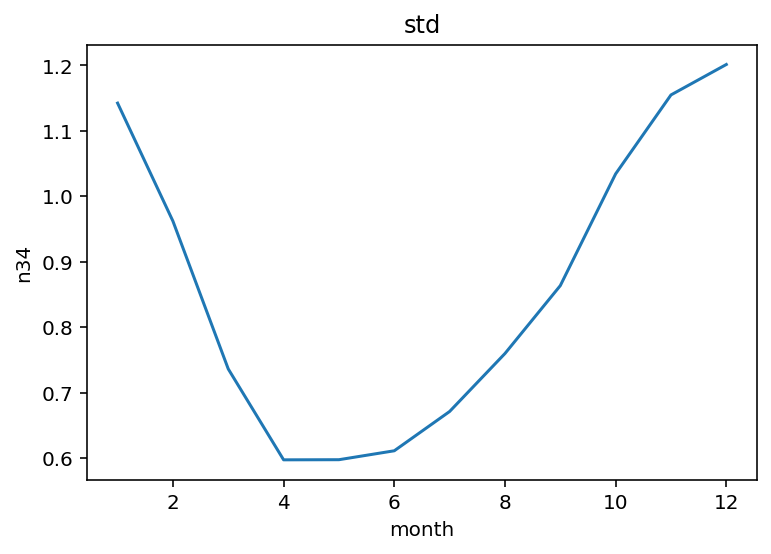

In [62]:
n34a.groupby('T.month').std(ddof = 1).plot()
plt.title('std');

The changes are larger than sampling variability

In [63]:
def std_by_month(x):
    nyears = np.floor_divide(len(x), 12)
    x2d = np.reshape(x[0:(nyears*12)], (nyears, 12))
    # bootstrap sampling to construct confidence intervals
    bootmax = 1000
    wrk = np.zeros((bootmax,12))
    for ii in range(0,bootmax):
        idx = np.random.choice(range(0,nyears),size=nyears)
        wrk[ii,:] = np.std(x2d[idx,:], ddof = 1, axis = 0)
    ci = np.percentile(wrk, np.array([5, 50, 95]), axis=0);
    return ci

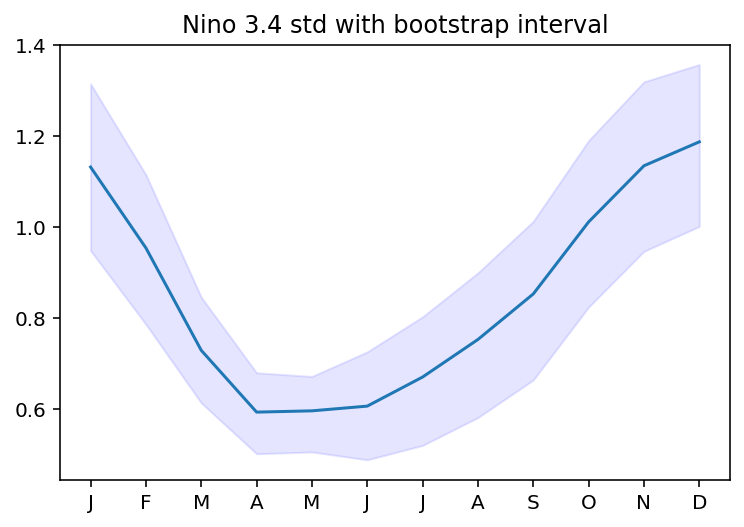

In [64]:
ci = std_by_month(n34a.values)
ci_obs = ci

fig, ax = plt.subplots()
ax.set_xticks(np.arange(0,12))
ax.set_xticklabels(m_str)
ax.fill_between(np.arange(0,12),ci[0,:], ci[2,:], color='b', alpha=.1)
ax.plot(np.arange(0,12), ci[1,:])
plt.title('Nino 3.4 std with bootstrap interval');

### 1.1 Fit AR(1) 
To demonstrate that AR(1) does not get this variability

In [65]:
from numpy.linalg import inv

y = n34a[1:].values
N = len(y)
X = np.empty((N,2)) + np.nan
X[:, 0] = 1.
X[:, 1] = n34a[0:-1]

beta = inv(X.T@X)@X.T@y
yhat = X@beta
R = y - yhat
sigma_R = np.std(R, ddof = 2)
phi1 = beta[1]

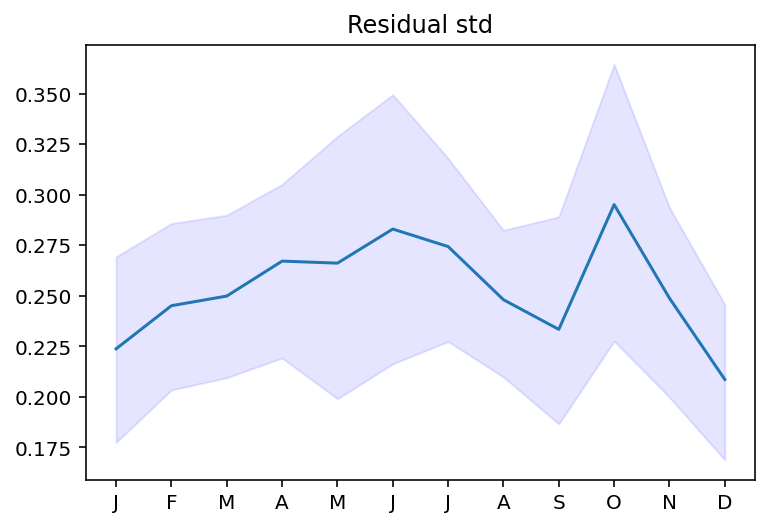

In [66]:
ci = std_by_month(np.roll(R,1))

fig, ax = plt.subplots()
ax.set_xticks(np.arange(0,12))
ax.set_xticklabels(m_str)
ax.fill_between(np.arange(0,12),ci[0,:], ci[2,:], color='b', alpha=.1)
ax.plot(np.arange(0,12), ci[1,:])
plt.title('Residual std');

No overwhelming evidence for residuals that vary by month

### 1.2 Simulate the AR(1)

In [67]:
x = np.empty(N) + np.nan
sigma_X = np.sqrt(sigma_R**2/(1 - phi1**2))
x[0] = np.random.normal(scale = sigma_X)
x[0] = n34a[0]
for ii in range(1, N):
    x[ii] = phi1 * x[ii - 1] + np.random.normal(scale = sigma_R)

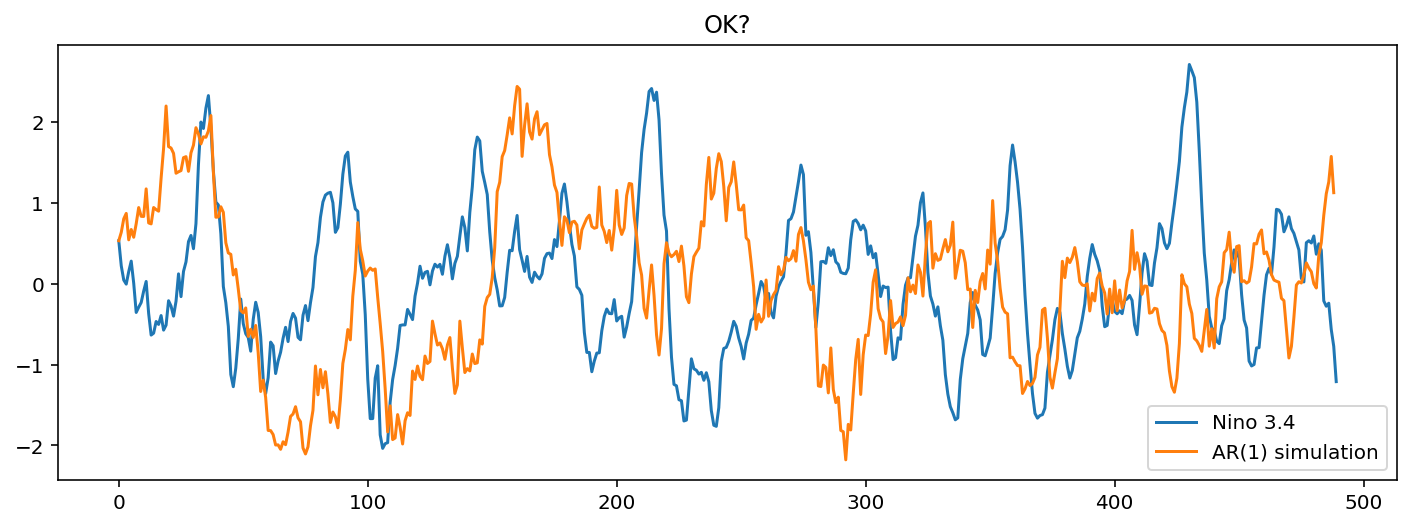

In [68]:
fig, ax = plt.subplots(figsize = (12, 4))
ax.plot(n34a.values, label = 'Nino 3.4')
ax.plot(x, label = 'AR(1) simulation');
ax.set_title('OK?');
ax.legend();

### 1.3 Check variance by month

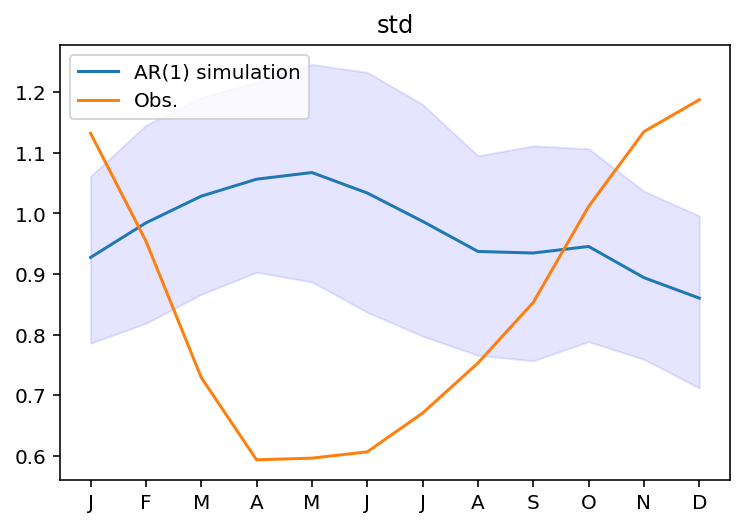

In [69]:
ci = std_by_month(np.roll(x,1))

fig, ax = plt.subplots()
#n34a.groupby('T.month').std(ddof = 1).plot(ax = ax)
ax.set_xticks(np.arange(0,12))
ax.set_xticklabels(m_str)
ax.fill_between(np.arange(0,12),ci[0,:], ci[2,:], color='b', alpha=.1)
ax.plot(np.arange(0,12),ci[1,:], label = 'AR(1) simulation')
ax.plot(np.arange(0,12),ci_obs[1,:], label = 'Obs.')
ax.legend()
ax.set_title('std');

### 1.4 Residuals are orthogonal to predictors ($X$)

Because regression is least-squares, and least-squares is projection.

![](images/ResidualsArePerp.pdf)

In [70]:
# And they are!
R.T @ X

array([ 8.10462808e-15, -1.76303416e-13])

Interpretation:

Residuals (errors) are uncorrelated with predictors. If errors were correlated with predictors, we could "fix" the errors by changing $\beta$.

(Picture above)

**But** residuals in some months do project onto predictors.

Recall the cosine of the angle $\theta$ between two vectors $a$ and $b$ (pretty much their correlation) is:
$$ \cos{\theta} = \frac{a^T b}{\|a\| \|b\|} $$

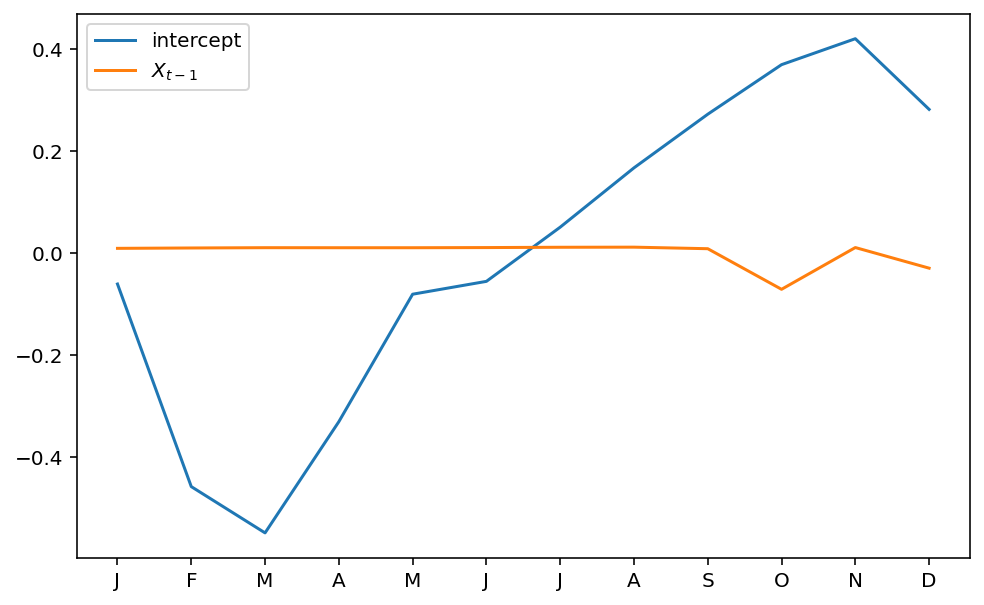

In [71]:
# compute correlation by month
dot = np.empty((12,2))
for imonth in range(0, 12):
    w1 = R[imonth::12]
    w2 = X[imonth::12, :]
    dot[imonth, :] = (w1.T @ w2)/np.sqrt(np.sum(w1**2)*np.sum(w2**2))

fig, ax = plt.subplots(figsize =(8, 5))    
ax.plot(np.roll(dot, 1))
ax.set_xticks(np.arange(0,12));
ax.set_xticklabels(m_str);
ax.legend(['intercept', '$X_{t-1}$']);

$R_t = X_t - \hat{X}_t = X_t - \phi X_{t-1}$ and $\phi \approx 0.95$ > 0.

So, the negative values in spring mean that $\hat{X}$ is too large in March, and the postive values mean that $\hat{X}$ is too small November.

The only way to fix this is to have a $\phi$ that varies by month.

Is there evidence that the autocorrelation is not just a function of the separation $\tau$?

In [72]:
def cor(x,y):
    xa = x - np.nanmean(x)
    ya = y - np.nanmean(y)
    return np.nansum(xa*ya)/np.sqrt(np.nansum(xa**2)*np.nansum(ya**2))

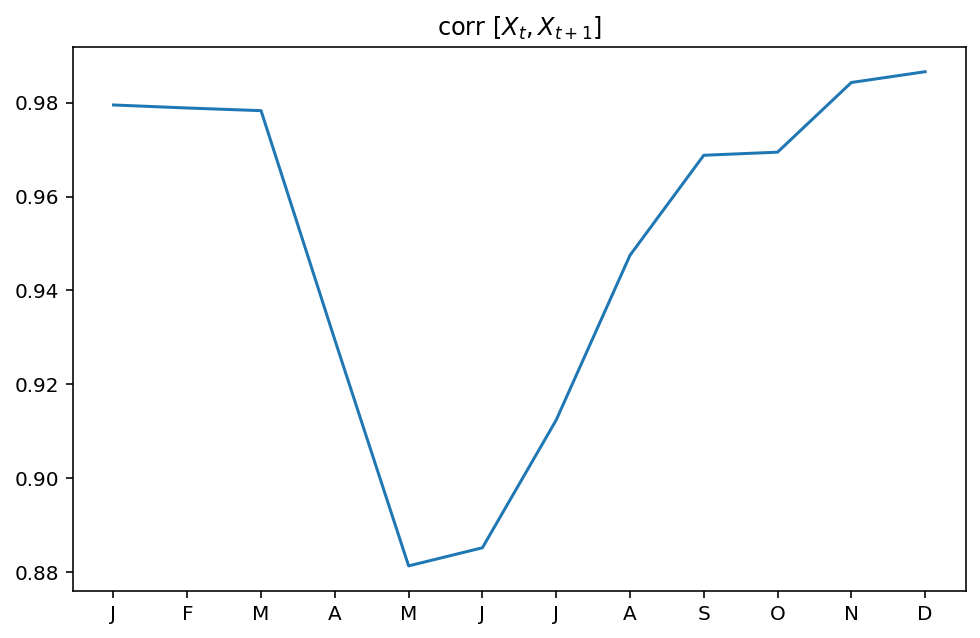

In [73]:
rho1 = np.empty(12) + np.nan
for imonth in range(0, 12):
    rho1[imonth] = cor(n34a[imonth::12], n34a.shift(T=1)[imonth::12])

fig, ax = plt.subplots(figsize =(8, 5))    
ax.plot(rho1)
ax.set_xticks(np.arange(0,12));
ax.set_xticklabels(m_str);
ax.set_title('corr [$X_t, X_{t+1}$]');

## 2. Periodic AR(1)

$$ X_{t} = \phi(t) X_{t-1} + W_t $$

where $\phi(t + 12) = \phi(t)$.

One approach: expand $\phi(t)$ in a Fourier series.

One harmonic $\phi(t) = a_0 + a_1 \sin (2\pi t/12) + b_1 \cos (2\pi t/12) $

$$ X_{t} = \left( a_0 + a_1 \sin (2\pi t/12) + b_1 \cos (2\pi t/12) \right) X_{t-1} + W_t $$

$$ X_{t} =  a_0 X_{t-1} + a_1 \sin (2\pi t/12) X_{t-1} + b_1 \cos (2\pi t/12) X_{t-1} + W_t $$



Two harmonics $\phi(t) = a_0 + a_1 \sin (2\pi t/12) + b_1 \cos (2\pi t/12) + a_2 \sin (4\pi t/12) + b_2 \cos (4\pi t/12) $



In [74]:
# one harmonic in Fourier series
from numpy.linalg import inv

y = n34a[1:].values
N = len(y)

mt = np.arange(0, N)/12.*2*np.pi

X = np.empty((N,4)) + np.nan
X[:, 0] = 1.
X[:, 1] = n34a[0:-1]
X[:, 2] = n34a[0:-1] * np.sin(mt)
X[:, 3] = n34a[0:-1] * np.cos(mt)

beta = inv(X.T@X)@X.T@y
yhat = X@beta
R = y - yhat
sigma_R = np.std(R, ddof = 4)
beta1 = beta
R1 = R

In [75]:
# two harmonics in Fourier series
from numpy.linalg import inv

y = n34a[1:].values
N = len(y)

mt = np.arange(0, N)/12.*2*np.pi

X = np.empty((N,6)) + np.nan
X[:, 0] = 1.
X[:, 1] = n34a[0:-1]
X[:, 2] = n34a[0:-1] * np.sin(mt)
X[:, 3] = n34a[0:-1] * np.cos(mt)
X[:, 4] = n34a[0:-1] * np.sin(2*mt)
X[:, 5] = n34a[0:-1] * np.cos(2*mt)


beta = inv(X.T@X)@X.T@y
yhat = X@beta
R = y - yhat
sigma_R = np.std(R, ddof = 6)
beta2 = beta

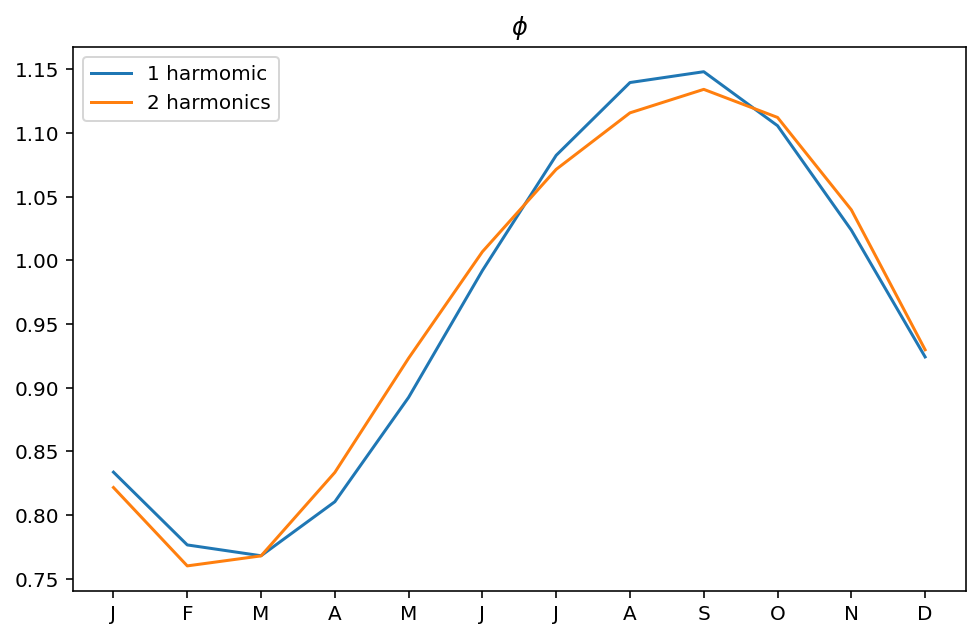

In [76]:
fig, ax = plt.subplots(figsize =(8, 5))    

ax.plot(beta1[1:] @ np.array([np.ones(12), np.sin(mt[:12]), np.cos(mt[:12])]),
        label = '1 harmomic')
ax.plot(beta2[1:] @ np.array([np.ones(12), np.sin(mt[:12]), np.cos(mt[:12]), np.sin(2*mt[:12]), np.cos(2*mt[:12])]),
        label = '2 harmonics')
ax.set_title('$\phi$')
ax.set_xticks(np.arange(0,12));
ax.set_xticklabels(m_str);

ax.legend();

Condition of $\phi$ for bounded solution?

$$ \prod_{i=1}^{12} \phi_i  < 1 $$

In [77]:
np.prod(beta1[1:] @ np.array([np.ones(12), np.sin(mt[:12]), np.cos(mt[:12])]))

0.5282051676306025

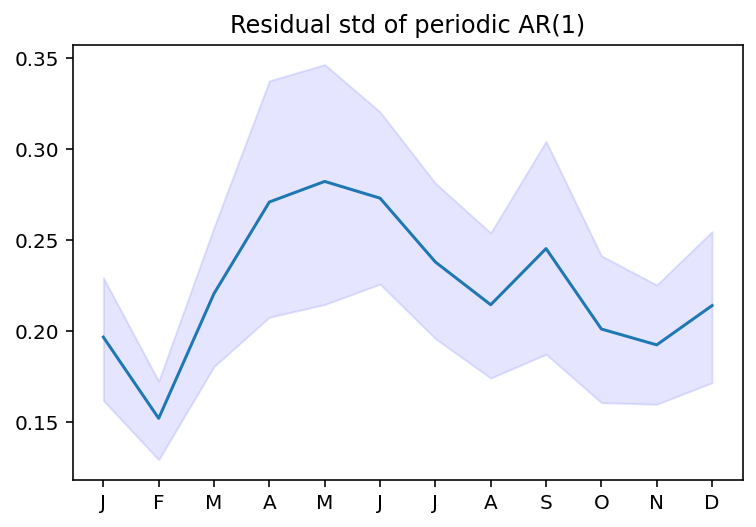

In [78]:
ci = std_by_month(R1)

fig, ax = plt.subplots()
ax.set_xticks(np.arange(0,12))
ax.set_xticklabels(m_str)
ax.fill_between(np.arange(0,12),ci[0,:], ci[2,:], color='b', alpha=.1)
ax.plot(np.arange(0,12), ci[1,:])
plt.title('Residual std of periodic AR(1)');

In [79]:
A = np.array([np.ones(12), np.sin(mt[:12]), np.cos(mt[:12])]).T
r_std = ci[1,:]
alpha = inv(A.T @ A) @ (A.T @ r_std)
r_std_proj = A @ alpha

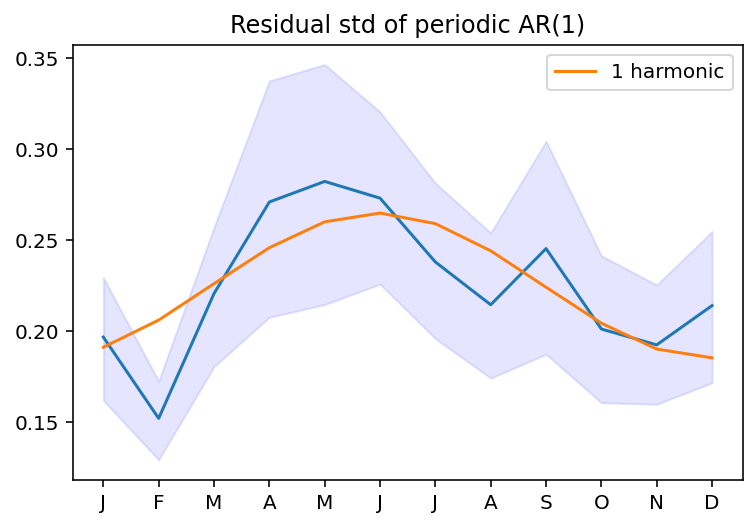

In [80]:
fig, ax = plt.subplots()
ax.set_xticks(np.arange(0,12))
ax.set_xticklabels(m_str)
ax.fill_between(np.arange(0,12),ci[0,:], ci[2,:], color='b', alpha=.1)
ax.plot(np.arange(0,12), ci[1,:])
ax.plot(np.arange(0,12), r_std_proj, label = '1 harmonic')
ax.legend()
ax.set_title('Residual std of periodic AR(1)');

In [81]:
# Simulate periodic AR1
np.random.seed(2)

beta = beta1
x = np.empty(N) + np.nan
x[0] = n34a[0]
for ii in range(1, N):
    sigma_r = np.array([1, np.sin(mt[ii]), np.cos(mt[ii])]) @ alpha
    x[ii] = beta[0] + beta[1:] @ (np.array([1, np.sin(mt[ii]), np.cos(mt[ii])]) * x[ii - 1]) + np.random.normal(scale = sigma_r)

# rename for use later in homework
x_periodic_AR1 = x

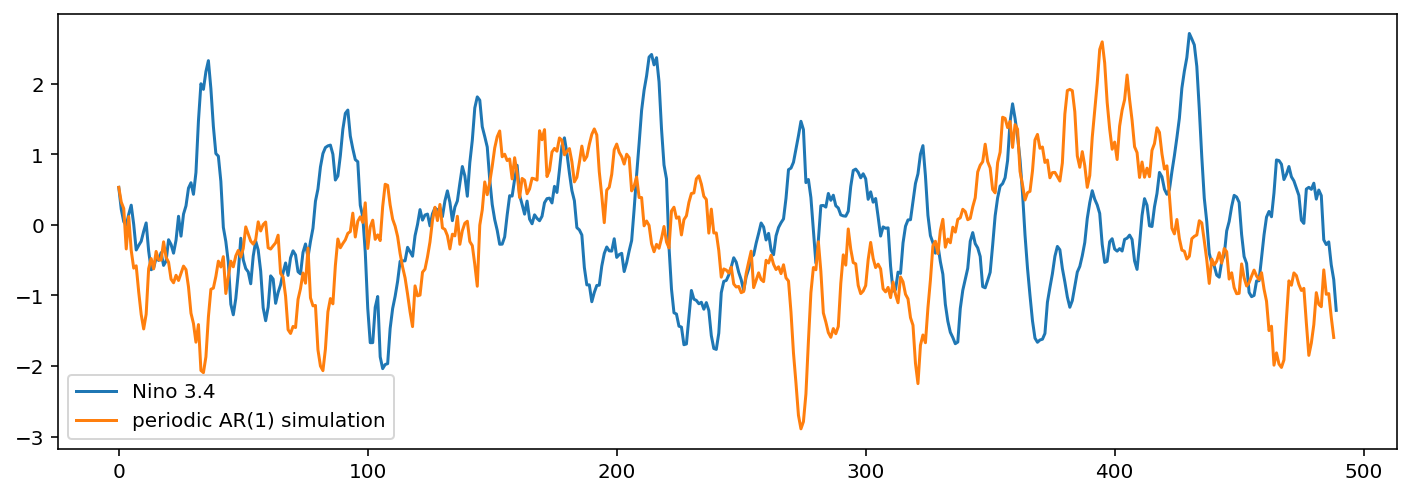

In [82]:
fig, ax = plt.subplots(figsize = (12, 4))
ax.plot(n34a.values, label = 'Nino 3.4')
ax.plot(x, label = 'periodic AR(1) simulation');

ax.legend();

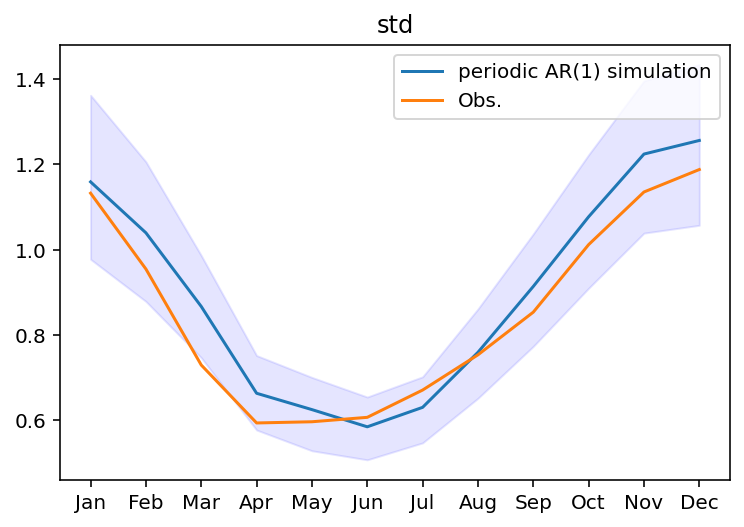

In [83]:
ci = std_by_month(np.roll(x,1))

fig, ax = plt.subplots()
#n34a.groupby('T.month').std(ddof = 1).plot(ax = ax)
ax.set_xticks(np.arange(0,12))
ax.set_xticklabels(month_str)
ax.fill_between(np.arange(0,12),ci[0,:], ci[2,:], color='b', alpha=.1)
ax.plot(np.arange(0,12),ci[1,:], label = 'periodic AR(1) simulation')
ax.plot(np.arange(0,12),ci_obs[1,:], label = 'Obs.')
ax.legend()
plt.title('std');

### 2.2 Residuals are still correlated

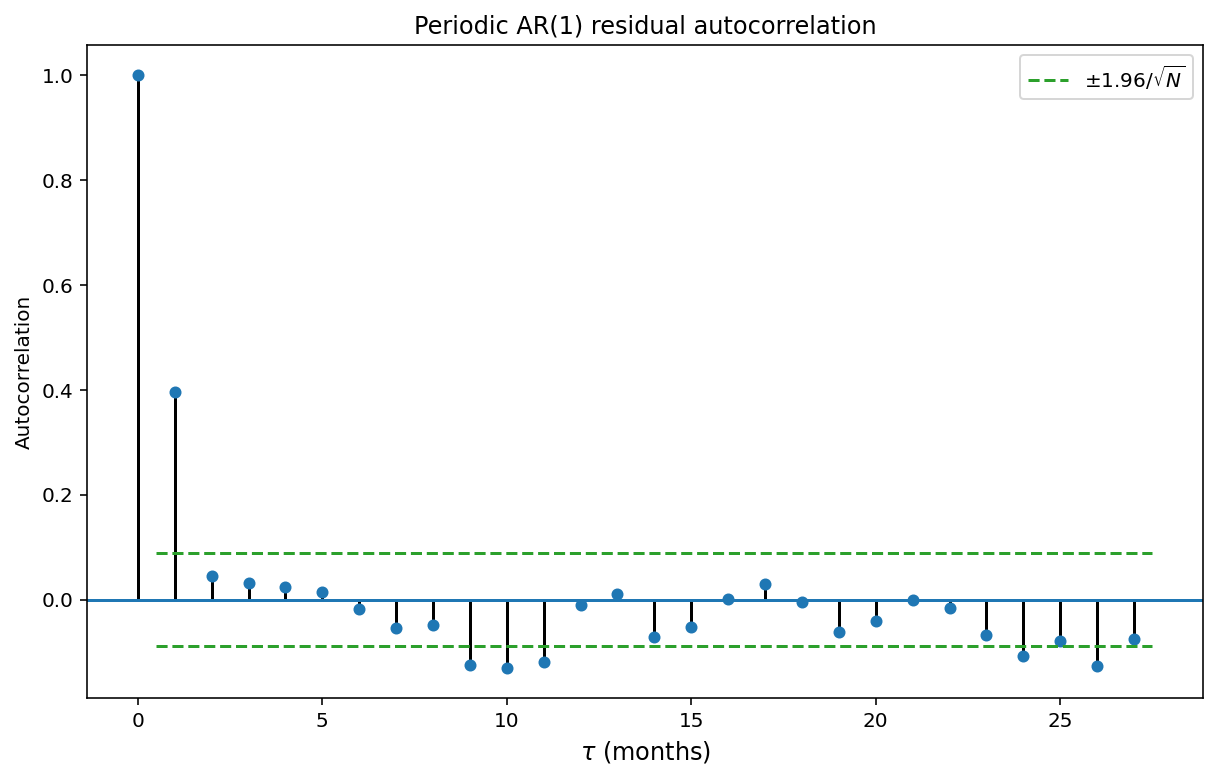

In [84]:
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(figsize = (10, 6))
#plot_acf(np.random.normal(size=nmonths), alpha = 0.05, ax = ax, title = 'Nino 3.4 autocorrelation');
plot_acf(R, alpha = None, ax = ax, title = 'Periodic AR(1) residual autocorrelation');

ax.set_xlabel(r'$\tau$ (months)', size = 12);
ax.set_ylabel('Autocorrelation')

c1 = np.ones(28)*1.96/np.sqrt(nmonths)
# interval for iid normal data
ax.plot(np.arange(0.5,28),  c1 , '--', color = colors[2], label = '$\pm 1.96/\sqrt{N}$')
ax.plot(np.arange(0.5,28), -c1 , '--', color = colors[2])
ax.legend();

## 3. Periodic AR2

$$ X_t = \phi_1(t) X_{t-1} + \phi_2(t) X_{t-2} + W_t $$

with 

$$\phi_1(t) = a_0 + a_1 \sin( 2 \pi t /12) + b_1 \cos( 2 \pi t/12) $$

$$\phi_2(t) = c_0 + d_1 \sin( 2 \pi t /12) + e_1 \cos( 2 \pi t/12) $$

### 3.1 Fit  

In [85]:
# one harmonic in Fourier series
from numpy.linalg import inv

y = n34a[2:].values
N = len(y)

mt = np.arange(0, N)/12.*2*np.pi

X = np.empty((N,7)) + np.nan
X[:, 0] = 1.
X[:, 1] = n34a[1:-1]
X[:, 2] = n34a[1:-1] * np.sin(mt)
X[:, 3] = n34a[1:-1] * np.cos(mt)
X[:, 4] = n34a[0:-2]
X[:, 5] = n34a[0:-2] * np.sin(mt)
X[:, 6] = n34a[0:-2] * np.cos(mt)


beta = inv(X.T@X)@X.T@y
yhat = X@beta
R = y - yhat
sigma_R = np.std(R, ddof = 4)
beta1 = beta

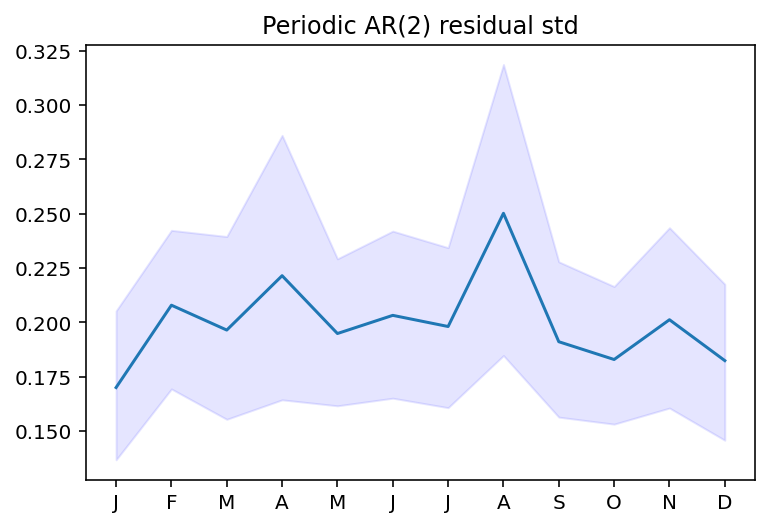

In [86]:
ci = std_by_month(R)

fig, ax = plt.subplots()
ax.set_xticks(np.arange(0,12))
ax.set_xticklabels(m_str)
ax.fill_between(np.arange(0,12),ci[0,:], ci[2,:], color='b', alpha=.1)
ax.plot(np.arange(0,12), ci[1,:])
plt.title('Periodic AR(2) residual std');

Smaller. No strong evidence for monthly varying noise.

### 3.2 Simulate 

In [87]:
np.random.seed(3)

x = np.empty(N) + np.nan
x[0:2] = n34a[0:2]
for ii in range(2, N):
    x[ii] = beta[0] + beta[1:4] @ np.array([1, np.sin(mt[ii]), np.cos(mt[ii])]) * x[ii - 1] + beta[4:] @ np.array([1, np.sin(mt[ii]), np.cos(mt[ii])]) * x[ii - 2] + np.random.normal(scale = sigma_R)

# rename for use later in homework
x_periodic_AR2 = x

<ipython-input-87-02dc85514c1f>:3: RuntimeWarning: invalid value encountered in add
  x = np.empty(N) + np.nan


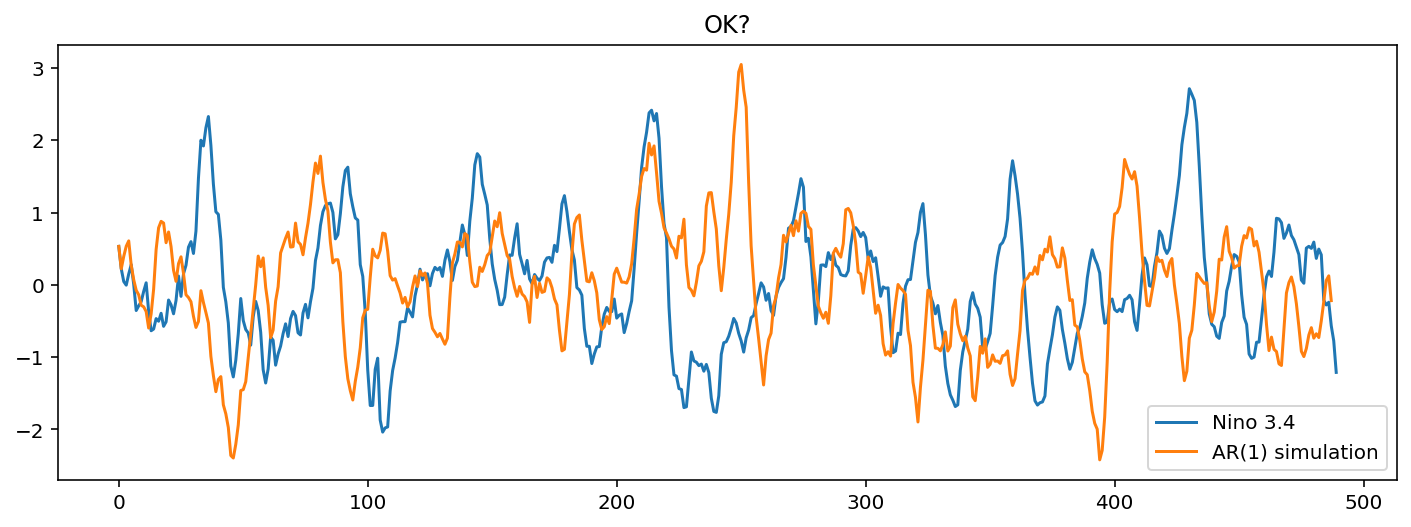

In [88]:
fig, ax = plt.subplots(figsize = (12, 4))
ax.plot(n34a.values, label = 'Nino 3.4')
ax.plot(x, label = 'AR(1) simulation');
ax.set_title('OK?');
ax.legend();

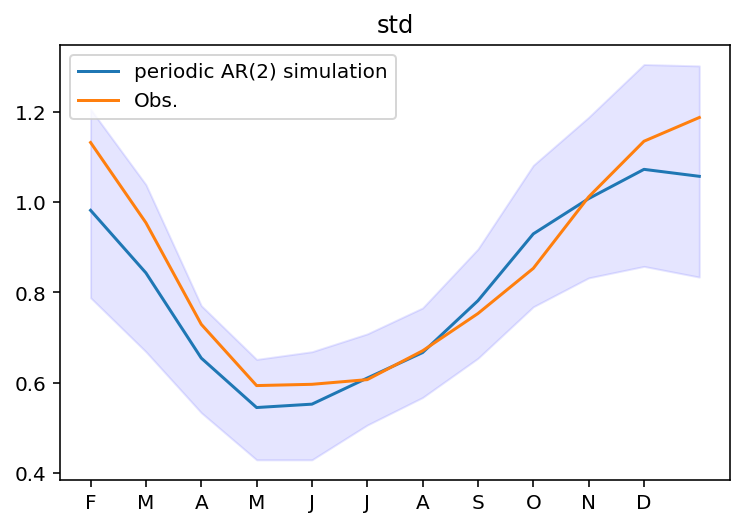

In [89]:
ci = std_by_month(np.roll(x,1))

fig, ax = plt.subplots()
#n34a.groupby('T.month').std(ddof = 1).plot(ax = ax)
ax.set_xticks(np.arange(0,12))
ax.set_xticklabels(m_str)
ax.fill_between(1 + np.arange(0,12),ci[0,:], ci[2,:], color='b', alpha=.1)
ax.plot(1 + np.arange(0,12),ci[1,:], label = 'periodic AR(2) simulation')
ax.plot(1 + np.arange(0,12),ci_obs[1,:], label = 'Obs.')
ax.legend()
ax.set_title('std');

### 3.2 Residuals are uncorrelated

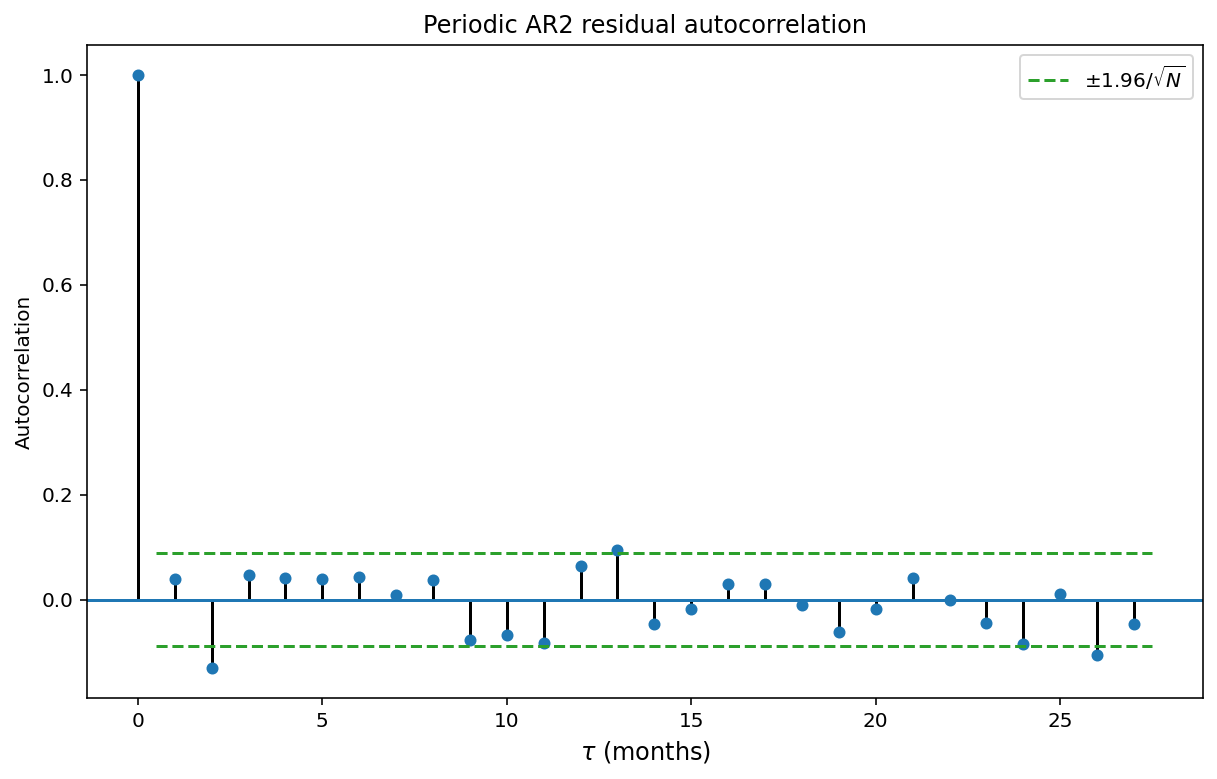

In [90]:
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(figsize = (10, 6))
#plot_acf(np.random.normal(size=nmonths), alpha = 0.05, ax = ax, title = 'Nino 3.4 autocorrelation');
plot_acf(R, alpha = None, ax = ax, title = 'Periodic AR2 residual autocorrelation');

ax.set_xlabel(r'$\tau$ (months)', size = 12);
ax.set_ylabel('Autocorrelation')

c1 = np.ones(28)*1.96/np.sqrt(nmonths)
# interval for iid normal data
ax.plot(np.arange(0.5,28),  c1 , '--', color = colors[2], label = '$\pm 1.96/\sqrt{N}$')
ax.plot(np.arange(0.5,28), -c1 , '--', color = colors[2])
ax.legend();

# Exercises

## 1. (20 points) 1. Project proposal (Turn in with homework)

Project ideas: 
1. ENSO blog index https://www.climate.gov/news-features/blogs/enso/index-page-enso-blog-posts
2. Possible formats/ideas
    - Reproduce/extend published work
    - Consider the role of ENSO on a topic that you have interest or experience
    - Ask me for an idea
    - Look at something from Michelle L'Heureux's talk
    - Look at SOI instead of Nino 3.4
    - Every lecture has gaps that could be filled and extended. For instance, what would the calculations of Walker look like using modern data?

Describe your project by answering the following questions.

1. What is the scientific question/hypothesis being addressed?

2. What previous work has been done? (For instance, give a few references).

3. What methods/approaches will be used?

4. What data will be used? Give as much detail as possible about the source, resolution (time and space), and format.

1. Question/ Hypothesis being addressed is: To find effective patterns in compressing data/features of maps of SST (sea surface temperature) ?
2. Previous work: 
Huang, B., P. W. Thorne, V. F. Banzon, T. Boyer, G. Chepurin, J. H. Lawrimore, M. J. Menne, T. M. Smith, R. S. Vose, and H.-M. Zhang, 2017: Extended Reconstructed Sea Surface Temperature, version 5 (ERSSTv5): Upgrades, validations, and intercomparisons. J. Climate, 30, 8179-8205, doi:10.1175/JCLI-D-16-0836.1.
Climatology used for dataset:
Reynolds, R. W., N. A. Rayner, T. M. Smith, D. C. Stokes, and W. Wang, 2002: An improved in situ and satellite SST analysis. J. Climate, 15, 1609-1625.
3. Method:
Utilize machine learning for Feature Compression/ Feature extraction for analysis in ENSO- SST 
image compression, recreate data, change layers in 2 or 3 outputs --> focused reduce 2/3 thirds. different number of output. 
4. Data used ? 
NOAA NCDC ERSST version1: Extended reconstructed global sea surface temperature data based on COADS data
Resolution: 2x2; Longitude: global; Latitude: global; Time: [Jan 1854,Jun 2005]; monthly
NOAA NCDC ERSST version2: Improved extended reconstructed global sea surface temperature data based on COADS data
Resolution: 2x2; Longitude: global; Latitude: global; Time: [Jan 1854,Dec 2009]; monthly
12 x number of years in example (100 yrs) ---> all data 1200 images. 
All fields were computed on the 2-degree grid. The grid has 180 zonal points on 0E, 2E, ..., 358E, and 89 meridional points on 88S, 86S, ..., 88N.
https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/.version5/.sst/



## 2. (20 points) A mean-zero AR(3) model has the form

$$ X_t = \phi_1 X_{t-1} + \phi_2 X_{t-2} + \phi_3 X_{t-3} + W_t $$ 

where $W_t$ is Gaussian white noise with mean zero and variance $\sigma_W^2$. Suppose that process is stationary with variance $\sigma_X^2$.

A. Show that $E[X_t] = 0$. (Take expectation of both sides of the above equation and use stationarity).

B. Multiply both sides of the equation above by $X_{t - k}/\sigma_X^2$ for $k > 0$ and take the expectation. Express the result using the autocorrelation function $\rho(\tau) = \text{cor} [X_t, X_{t-\tau} ]$. 

C. Use the result from B and set $k = 1, 2, 3$ to obtain 3 equations involving the $\phi$'s and $\rho(1)$, $\rho(2)$, and $\rho(3)$. Use the fact that $\rho(\tau)$ is an even function of $\tau$.

D. Use the values of $\rho(1)$, $\rho(2)$, and $\rho(3)$ and solve for $\phi_1$, $\phi_2$, $\phi_3$.

E. (Extra credit) Use the $k=0$ equation to solve for $\sigma_W^2$.

Please see attached images in courseworks. Thanks

In [91]:
from statsmodels.tsa.stattools import acf
rho = acf(n34a, unbiased = True, fft = False)
rho[1:4]

array([0.95580022, 0.86899297, 0.765247  ])

## 3. (15 points) Confidence intervals for the lag-1 correlation of Nino 3.4.

Write a function to compute confidence intervals for the lag-1 correlation of Nino 3.4 that uses bootstrap sampling.

In [107]:
def lag1_cor_by_month(x):
    # your code here
    # bootstrap confidence intervals
    from numpy.random import seed
    from numpy.random import rand
    from numpy.random import randint
    from numpy import mean
    from numpy import median
    from numpy import percentile
   
    seed(83)
    # bootstrap
    scores = list()
    for _ in range(100):
      # bootstrap sample
      indices = randint(0, 1000, 1000)
      sample = dataset[indices]
      # calculate and store statistic
      statistic = mean(sample)
      scores.append(statistic)
    print('50th percentile (median) = %.3f' % median(scores))
    # calculate 95% confidence intervals (100 - alpha)
    alpha = 5.0
    # calculate lower percentile (e.g. 2.5)
    lower_p = alpha / 2.0
    # retrieve observation at lower percentile
    lower = max(0.0, percentile(scores, lower_p))
    print('%.1fth percentile = %.3f' % (lower_p, lower))
    # calculate upper percentile (e.g. 97.5)
    upper_p = (100 - alpha) + (alpha / 2.0)
    # retrieve observation at upper percentile
    upper = min(1.0, percentile(scores, upper_p))
    print('%.1fth percentile = %.3f' % (upper_p, upper)
   
    ci = np.percentile(wrk, np.array([5, 50, 95]), axis=0);
    return ci

SyntaxError: invalid syntax (<ipython-input-107-79ad17a8ce92>, line 35)

Add confidence intervals to this plot

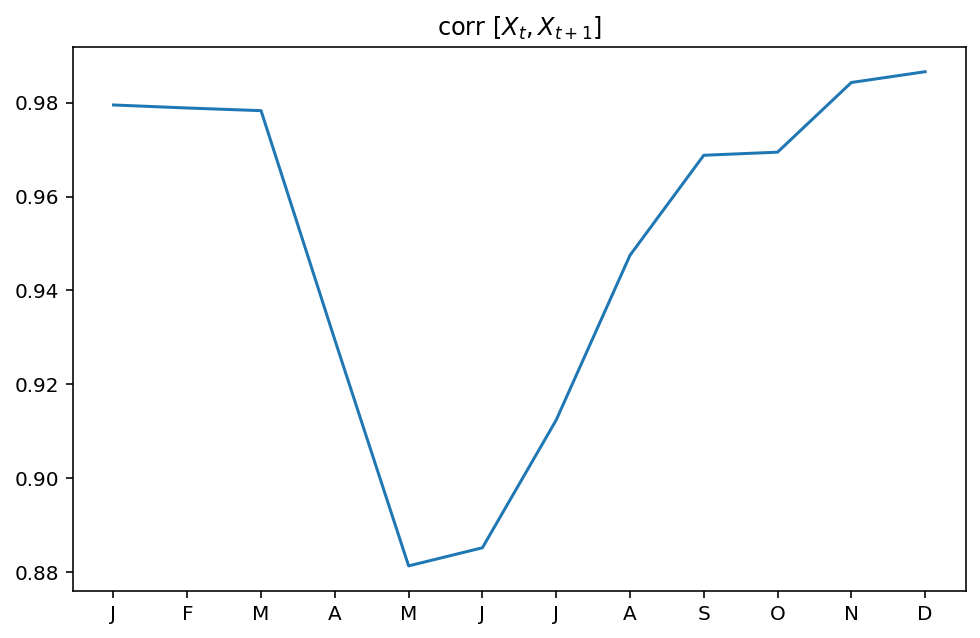

In [98]:
rho1 = np.empty(12) + np.nan
for imonth in range(0, 12):
    rho1[imonth] = cor(n34a[imonth::12], n34a.shift(T=1)[imonth::12])

fig, ax = plt.subplots(figsize =(8, 5))    
ax.plot(rho1)
ax.set_xticks(np.arange(0,12));
ax.set_xticklabels(m_str);
ax.set_title('corr [$X_t, X_{t+1}$]');

## 4. (20 points) The lag-correlation of Nino 3.4 has a distinctive structure (below). 

Compute and plot the quantity 

$$ C_{t, \tau} = \text{cor} [ X_t, X_{t+\tau} ]\,, \qquad t = \text{ Jan, ..., Dec}\,, \quad \tau = 1, \dots, 12$$


for the periodic AR(1) and periodic AR(2) simulations computed above. The code below works (I think) for Nino 3.4 which is an xarray array.

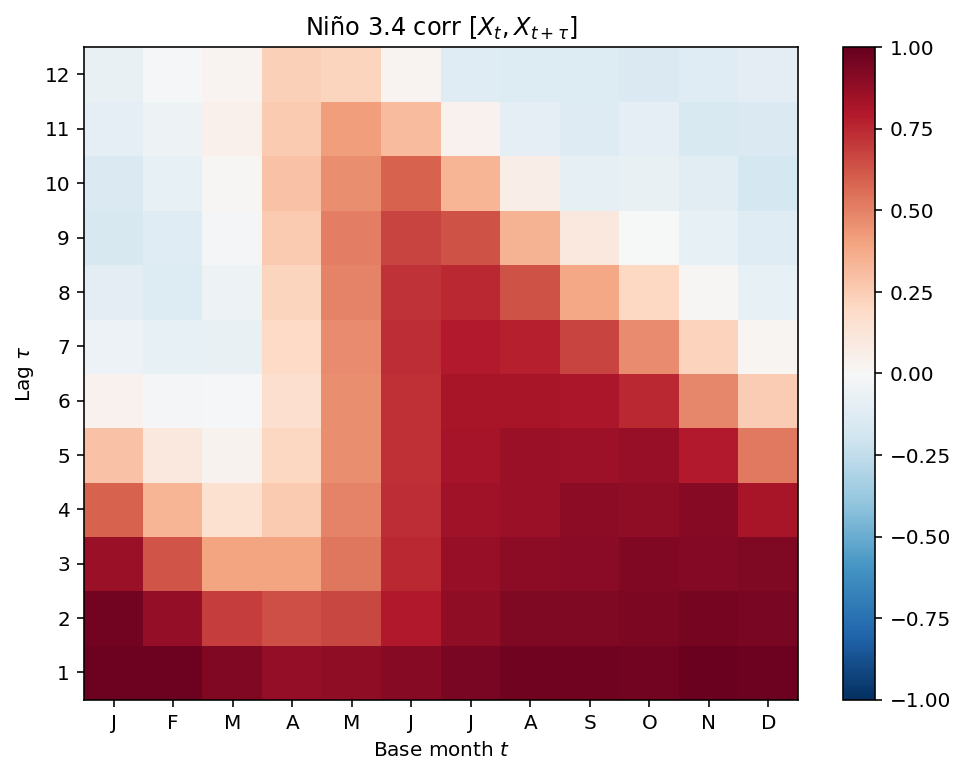

In [108]:
max_lag = 12
cc = np.empty((12,12))
for imonth in range(0, 12):
    for lag in range(1, max_lag + 1):
        cc[lag - 1, imonth] = cor(n34a[imonth::12], n34a.shift(T = -lag)[imonth::12])

fig, ax = plt.subplots(figsize = (8, 6))        
g = ax.pcolormesh(np.arange(0, 12 + 1), np.arange(0, max_lag + 1) + 0.5, cc, vmax=1, vmin=-1, cmap='RdBu_r')
ax.set_xticks(np.arange(0, 12) + 0.5)
ax.set_xticklabels(m_str)
ax.set_yticks(np.arange(1, max_lag + 1))
plt.colorbar(g)
ax.set_xlabel('Base month $t$')
ax.set_ylabel(r'Lag $\tau$')
ax.set_title(r'Niño 3.4 corr $[X_t, X_{t + \tau}]$');

In [109]:
max_lag = 12
cc = np.empty((12,12))
for imonth in range(0, 12):
    for lag in range(1, max_lag + 1):
        cc[lag - 1, imonth] = cor(x_periodic_AR1[imonth::12],x_periodic_AR1.shift(T = -lag)[imonth::12])

fig, ax = plt.subplots(figsize = (8, 6))        
g = ax.pcolormesh(np.arange(0, 12 + 1), np.arange(0, max_lag + 1) + 0.5, cc, vmax=1, vmin=-1, cmap='RdBu_r')
ax.set_xticks(np.arange(0, 12) + 0.5)
ax.set_xticklabels(m_str)
ax.set_yticks(np.arange(1, max_lag + 1))
plt.colorbar(g)
ax.set_xlabel('Base month $t$')
ax.set_ylabel(r'Lag $\tau$')
ax.set_title(r'Niño 3.4 corr $[X_t, X_{t + \tau}]$');

AttributeError: 'numpy.ndarray' object has no attribute 'shift'

In [110]:
max_lag = 12
cc = np.empty((12,12))
for imonth in range(0, 12):
    for lag in range(1, max_lag + 1):
        cc[lag - 1, imonth] = cor(x_periodic_AR2[imonth::12],x_periodic_AR2.shift(T = -lag)[imonth::12])

fig, ax = plt.subplots(figsize = (8, 6))        
g = ax.pcolormesh(np.arange(0, 12 + 1), np.arange(0, max_lag + 1) + 0.5, cc, vmax=1, vmin=-1, cmap='RdBu_r')
ax.set_xticks(np.arange(0, 12) + 0.5)
ax.set_xticklabels(m_str)
ax.set_yticks(np.arange(1, max_lag + 1))
plt.colorbar(g)
ax.set_xlabel('Base month $t$')
ax.set_ylabel(r'Lag $\tau$')
ax.set_title(r'Niño 3.4 corr $[X_t, X_{t + \tau}]$')

AttributeError: 'numpy.ndarray' object has no attribute 'shift'